<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/mnist_confused_logits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Confused Logit: https://www.pytorchlightning.ai/blog/looking-inside-the-blackbox-how-to-trick-a-neural-network <br>
https://pytorch-lightning-bolts.readthedocs.io/en/stable/vision_callbacks.html

<img src="https://pytorch-lightning-bolts.readthedocs.io/en/stable/_images/confused_logit.png">


In [30]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=False

Prepare dataset

In [31]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


Architecture and training script

In [32]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x



def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        # #Print out the loss periodically. 
        # if batch_idx % args['log_interval'] == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    return test_loss, correct




Train the model

In [33]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test_loss, correct = test()
    print('Test set: Epoch:{}, Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Epoch:1, Average loss: 2.1123, Accuracy: 5293/10000 (53%)
Test set: Epoch:2, Average loss: 1.2857, Accuracy: 7387/10000 (74%)
Test set: Epoch:3, Average loss: 0.6766, Accuracy: 8419/10000 (84%)
Test set: Epoch:4, Average loss: 0.4995, Accuracy: 8730/10000 (87%)
Test set: Epoch:5, Average loss: 0.4099, Accuracy: 8889/10000 (89%)
Test set: Epoch:6, Average loss: 0.3514, Accuracy: 9009/10000 (90%)
Test set: Epoch:7, Average loss: 0.3151, Accuracy: 9095/10000 (91%)
Test set: Epoch:8, Average loss: 0.2899, Accuracy: 9181/10000 (92%)
Test set: Epoch:9, Average loss: 0.2652, Accuracy: 9237/10000 (92%)
Test set: Epoch:10, Average loss: 0.2490, Accuracy: 9270/10000 (93%)


Visualize first 100 samples and correcponding prediction

In [34]:
import numpy as np

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=False, **kwargs)


x, y = next(iter(train_loader))
#x = x.view(x.size(0), -1)
sample = 13
for sample in range(100):
    input = torch.nn.Parameter(x[sample])
    outputs = model(input[None])
    prob = F.softmax(outputs, dim=-1)
    pred = outputs.max(1, keepdim=True)[1]
    print(sample, pred, y[sample],round(prob.max().item(),2), np.round(prob.detach().numpy(),3))
#print(preds,'\n', prob)

0 tensor([[3]]) tensor(5) 0.72 [[0.    0.    0.007 0.72  0.    0.269 0.    0.001 0.003 0.   ]]
1 tensor([[0]]) tensor(0) 1.0 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
2 tensor([[4]]) tensor(4) 0.89 [[0.    0.    0.002 0.001 0.89  0.001 0.003 0.003 0.002 0.098]]
3 tensor([[1]]) tensor(1) 0.98 [[0.    0.981 0.002 0.003 0.    0.    0.001 0.002 0.011 0.   ]]
4 tensor([[9]]) tensor(9) 0.89 [[0.    0.    0.    0.    0.099 0.001 0.    0.006 0.001 0.893]]
5 tensor([[2]]) tensor(2) 0.71 [[0.005 0.007 0.712 0.095 0.002 0.002 0.001 0.048 0.114 0.013]]
6 tensor([[1]]) tensor(1) 0.96 [[0.    0.961 0.006 0.021 0.    0.001 0.002 0.001 0.007 0.001]]
7 tensor([[3]]) tensor(3) 1.0 [[0.    0.    0.    0.999 0.    0.001 0.    0.    0.    0.   ]]
8 tensor([[1]]) tensor(1) 0.96 [[0.    0.963 0.001 0.017 0.001 0.004 0.001 0.003 0.007 0.004]]
9 tensor([[4]]) tensor(4) 0.98 [[0.    0.    0.    0.    0.983 0.    0.001 0.    0.    0.015]]
10 tensor([[3]]) tensor(3) 1.0 [[0.    0.    0.    0.997 0.    0.003 0.    0.    0

Get output for a selected sample:

In [35]:
sample = 22
input = torch.nn.Parameter(x[sample])
outputs = model(input[None])
prob = F.softmax(outputs, dim=-1)
pred = outputs.max(1, keepdim=True)[1]
print(sample, pred, y[sample],round(prob.max().item(),2), np.round(prob.detach().numpy(),3))

22 tensor([[9]]) tensor(9) 0.58 [[0.    0.002 0.001 0.002 0.336 0.006 0.001 0.045 0.028 0.579]]


tensor(-0.2223)


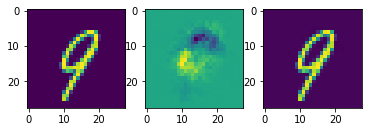

In [36]:
import matplotlib.pyplot as plt
# calculate gradient of 6th output with respect to the input (param)
desire_label_index = 4
label_5_pred = prob[0, desire_label_index]
label_5_pred.backward()

grad_img = input.grad.view(28, 28)
print(grad_img.sum())

plt.subplot(1,3,1)
plt.imshow(input[0].detach().numpy())

plt.subplot(1,3,2)
plt.imshow(grad_img)

plt.subplot(1,3,3)
fused_img = input[0].detach().numpy() + grad_img.detach().numpy()
plt.imshow(fused_img)

Fuse the gradient properly:

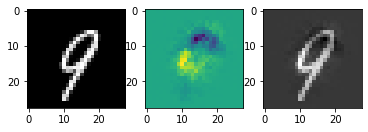

In [37]:
import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

plt.subplot(1,3,1)
plt.imshow(input[0].detach().numpy(), cmap='gray')

plt.subplot(1,3,2)
plt.imshow(grad_img)

plt.subplot(1,3,3)
fused_img = NormalizeData(input[0].detach().numpy()) + NormalizeData(grad_img.detach().numpy())
plt.imshow(fused_img, cmap='gray')

Prediction with fused gradient image to get desire prediction:

In [ ]:
outputs = model(torch.tensor(fused_img)[None, None])
prob = F.softmax(outputs, dim=-1)
pred = outputs.max(1, keepdim=True)[1]
print(sample, pred, y[sample],round(prob.max().item(),2), np.round(prob.detach().numpy(),3))

22 tensor([[4]]) tensor(9) 0.26 [[0.027 0.035 0.146 0.039 0.258 0.078 0.13  0.023 0.153 0.11 ]]


Fuse as lib: https://www.pytorchlightning.ai/blog/looking-inside-the-blackbox-how-to-trick-a-neural-network

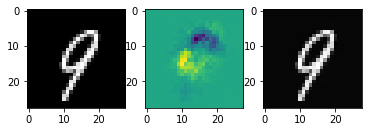

In [38]:
import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

plt.subplot(1,3,1)
plt.imshow(input[0].detach().numpy(), cmap='gray')

plt.subplot(1,3,2)
plt.imshow(grad_img)

plt.subplot(1,3,3)
fused_img = input[0].detach().numpy() + 2 * grad_img.detach().numpy()
plt.imshow(fused_img, cmap='gray')

In [39]:
outputs = model(torch.tensor(fused_img)[None, None])
prob = F.softmax(outputs, dim=-1)
pred = outputs.max(1, keepdim=True)[1]
print(sample, pred, y[sample],round(prob.max().item(),2), np.round(prob.detach().numpy(),3))

22 tensor([[4]]) tensor(9) 0.48 [[0.    0.001 0.001 0.001 0.484 0.006 0.002 0.025 0.023 0.456]]
